In [2]:
import os
import copy
import time
import cv2 
import numpy as np 
import random
from PIL import Image 
from copy import deepcopy 
import matplotlib.pyplot as plt
from collections import deque, defaultdict
from typing import Any, Dict, List, Optional, Set, Tuple, Union
from numpy.typing import ArrayLike, NDArray
from pydantic import dataclasses, validator

import dm_control
from dm_control import mujoco as dm_mujoco
from dm_control.utils.transformations import mat_to_quat, quat_to_euler
import mujoco
from rocobench.envs import SortOneBlockTask, CabinetTask, MoveRopeTask, SweepTask, MakeSandwichTask, PackGroceryTask, MujocoSimEnv, SimRobot, visualize_voxel_scene

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
env = PackGroceryTask(
    render_freq=2000,
    image_hw=(400,400), # Potentially important for getting RGBD images later on
    sim_forward_steps=300, # number of time steps forward that mujoco simulates before deciding that the llms need to pick an easier to optimize plan
    error_freq=30,
    error_threshold=1e-5,
    randomize_init=True,
    render_point_cloud=0, # Potentially useful for speeding up point fusion
    render_cameras=["face_panda","face_ur5e","teaser",], # potentially useful for getting rgbd images
    one_obj_each=True, # TODO: Understand this
)

In [27]:
print(f"|{env.model.id2name(48, 'body')}|")

|bread|


In [25]:
print(env.model.geom(171))

<_MjModelGeomViews
  bodyid: array([48], dtype=int32)
  conaffinity: array([0], dtype=int32)
  condim: array([3], dtype=int32)
  contype: array([0], dtype=int32)
  dataid: array([101], dtype=int32)
  friction: array([1.e+00, 5.e-03, 1.e-04])
  gap: array([0.])
  group: array([1], dtype=int32)
  id: 171
  margin: array([0.])
  matid: array([19], dtype=int32)
  name: ''
  pos: array([-1.37129086e-10, -5.06917629e-11, -2.52431306e-09])
  priority: array([0], dtype=int32)
  quat: array([ 7.07106781e-01,  7.07106781e-01,  5.44504416e-07, -5.44504416e-07])
  rbound: array([0.08508684])
  rgba: array([0.5, 0.5, 0.5, 1. ], dtype=float32)
  sameframe: array([0], dtype=uint8)
  size: array([0.04200003, 0.04331014, 0.06      ])
  solimp: array([9.0e-01, 9.5e-01, 1.0e-03, 5.0e-01, 2.0e+00])
  solmix: array([1.])
  solref: array([0.02, 1.  ])
  type: array([7], dtype=int32)
  user: array([], dtype=float64)
>


In [22]:
print(f"|{env.model.name2id('apple_visual', 'geom')}|")

|160|


In [4]:
pointcloud = env.get_point_cloud()

(<MjvGeom
  camdist: 0.02819684147834778
  category: 1
  dataid: 0
  emission: 0.0
  label: ''
  mat: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)
  modelrbound: 0.0
  objid: 0
  objtype: 5
  pos: array([ 0. ,  0. , -0.5], dtype=float32)
  reflectance: 0.20000000298023224
  rgba: array([1., 1., 1., 1.], dtype=float32)
  segid: 0
  shininess: 0.5
  size: array([0.  , 0.  , 0.05], dtype=float32)
  specular: 0.5
  texcoord: 0
  texid: 1
  texrepeat: array([2., 2.], dtype=float32)
  texuniform: 1
  transparent: 0
  type: 0
>, <MjvGeom
  camdist: -0.9953964948654175
  category: 1
  dataid: -1
  emission: 0.0
  label: ''
  mat: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)
  modelrbound: 1.649999976158142
  objid: 9
  objtype: 5
  pos: array([0. , 0.5, 0.1], dtype=float32)
  reflectance: 0.0
  rgba: array([1., 1., 1., 1.], dtype=float32)
  segid: 1
  shininess: 0.5
  size: array([1.6 , 0.4 , 0.05], dtype=float32)
  specular: 

In [4]:
print(pointcloud.segmentation_pts.keys())

dict_keys(['panda_link1', 'right_coupler', 'banana', 'right_follower', 'world', 'right_spring_link', 'soda_can', 'ur5e_0_wrist_2_link', 'left_spring_link', 'right_silicone_pad', 'cereal', 'panda_right_finger', 'panda_link6', 'left_coupler', 'left_follower', 'bread', 'panda_palm', 'panda_link5', 'left_driver', 'panda_link7', 'panda', 'apple', 'panda_link2', 'right_pad', 'milk', 'panda_left_finger', 'panda_link0'])


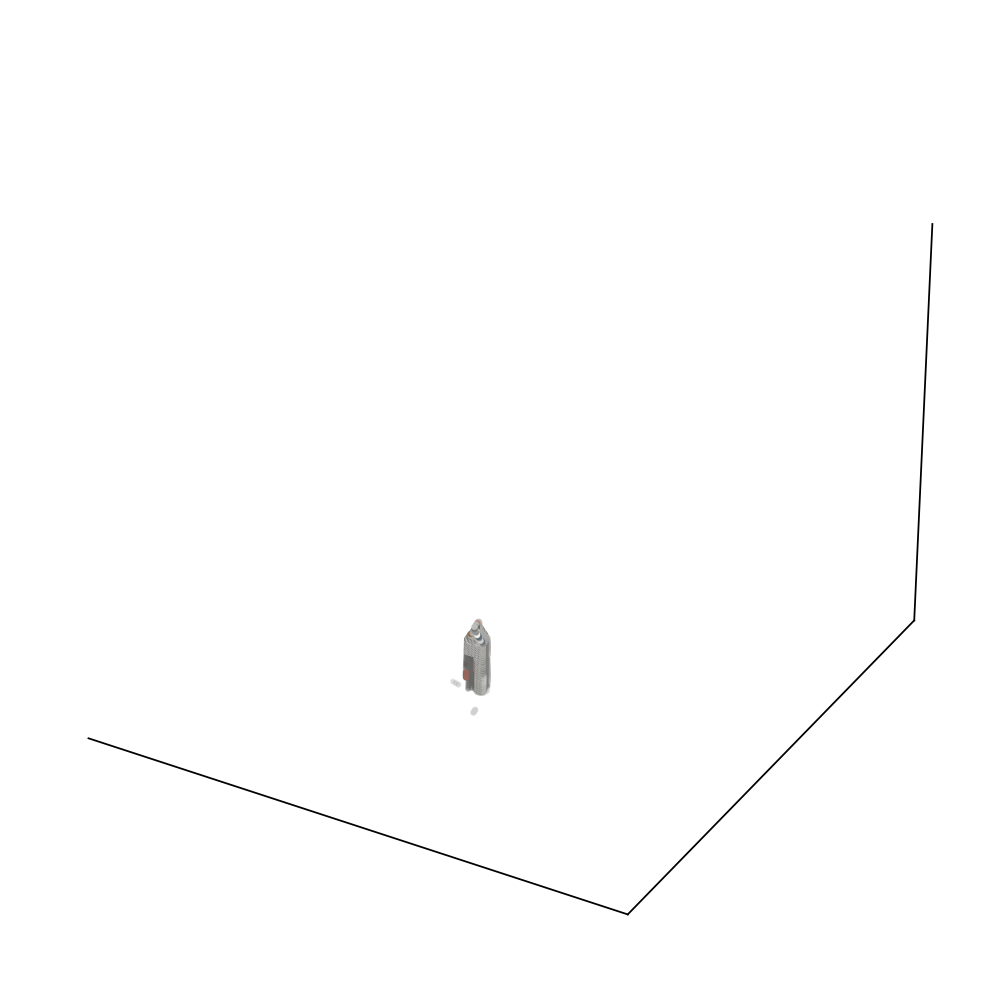

In [7]:
pointcloud['milk'].show()

0.2548343 0.3274017
0.025863938 0.08980163
0.629105 0.6436234


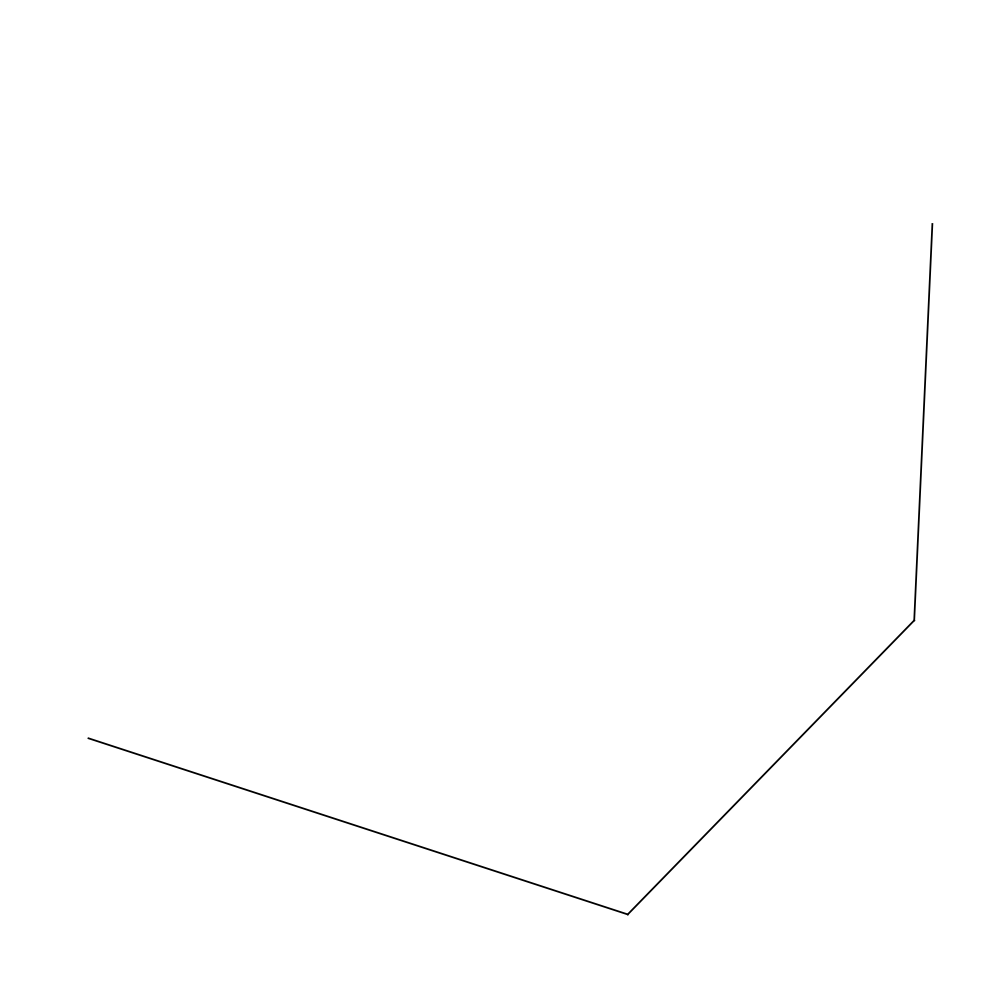

In [9]:
obj = "cereal"
print(min(pointcloud['banana'].xyz_pts[:,0]), max(pointcloud['banana'].xyz_pts[:,0]))
print(min(pointcloud['banana'].xyz_pts[:,1]), max(pointcloud['banana'].xyz_pts[:,1]))
print(min(pointcloud['banana'].xyz_pts[:,2]), max(pointcloud['banana'].xyz_pts[:,2]))
minx = min(pointcloud[obj].xyz_pts[:,0])
maxx = max(pointcloud[obj].xyz_pts[:,0])
miny = min(pointcloud[obj].xyz_pts[:,1])
maxy = max(pointcloud[obj].xyz_pts[:,1])
minz = min(pointcloud[obj].xyz_pts[:,2])
maxz = max(pointcloud[obj].xyz_pts[:,2])
bounds = ((minx, miny, minz), (maxx, maxy, maxz))
pointcloud['banana'].show(pts_size=1, bounds=bounds)

In [6]:
import numpy as np

x = np.random.random((10, 10))
mask = np.zeros((10,10), dtype=bool)
mask[:5, :5] = True
print(mask)
print(x[mask])

[[ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [ True  True  True  True  True False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]]
[0.15526954 0.38711336 0.65524037 0.90591685 0.79478943 0.12416552
 0.98782218 0.68689031 0.16404505 0.41641861 0.41725073 0.68258238
 0.11327336 0.32393565 0.61010668 0.21217516 0.45632832 0.01593102
 0.08516117 0.14924246 0.89810792 0.73851215 0.67850152 0.56231131
 0.88308163]


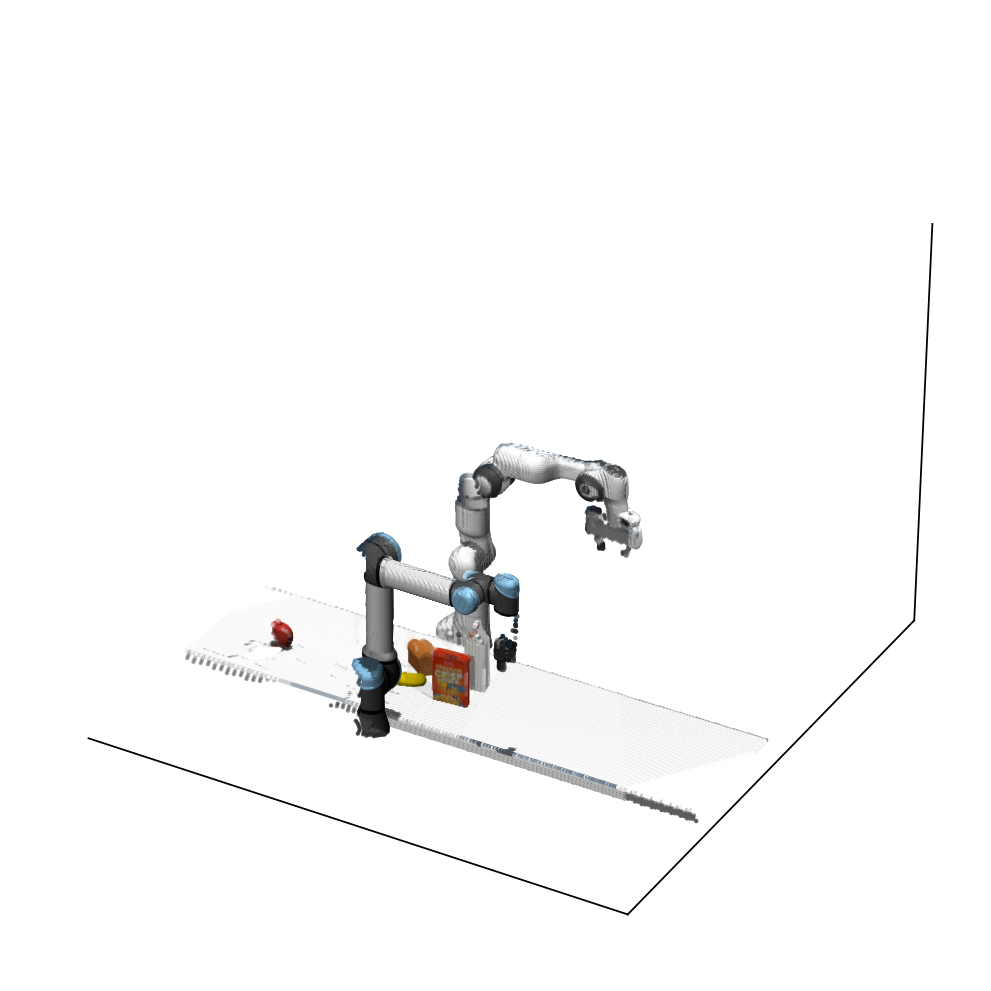

In [6]:
pointcloud.show(excluding=, pts_size=1)

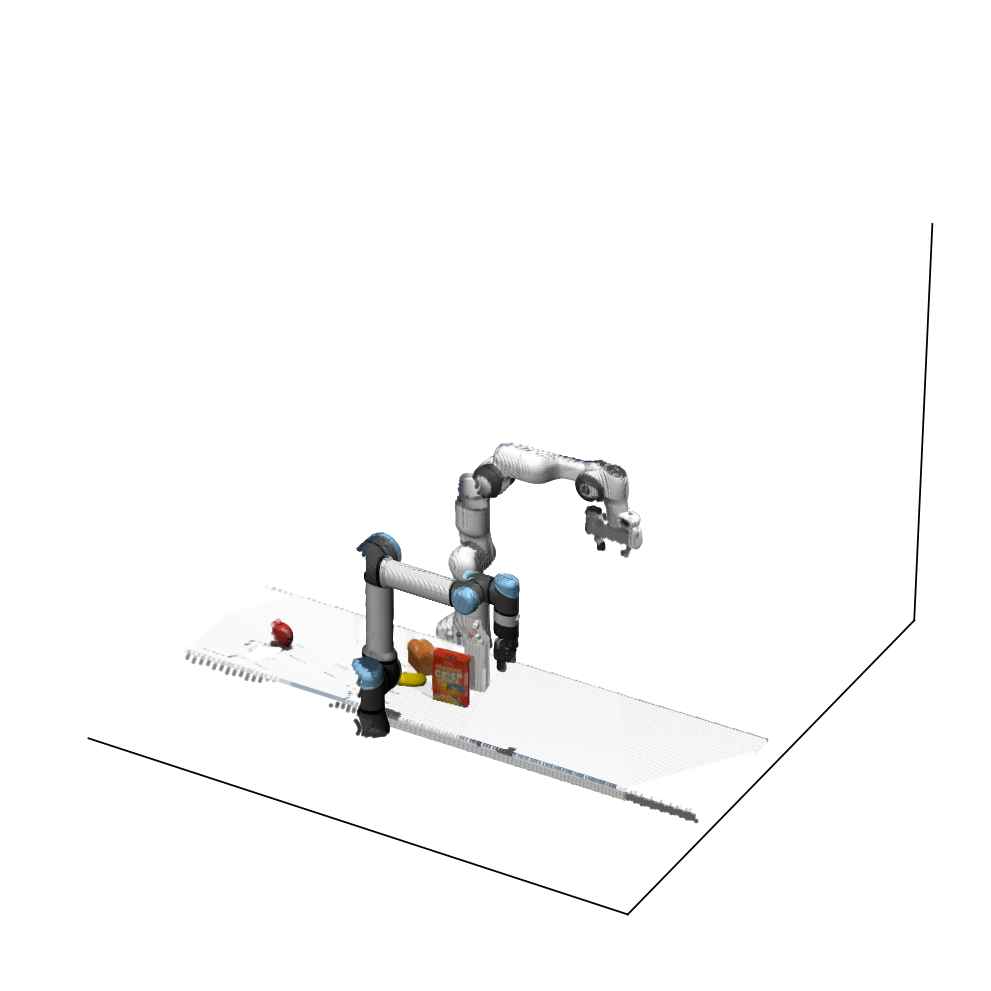

In [8]:
pointcloud.show(pts_size=1)

In [19]:
for task_object in env.task_objects:
    gnum = env.physics.model.body(task_object).geomadr
    gadr = env.physics.model.body(task_object).geomnum
    id = env.physics.model.body(task_object).id
    print(f"Task object: {task_object}, gnum: {gnum}, gadr: {gadr}, id: {id}")


Task object: bin, gnum: [153], gadr: [2], id: 40
Task object: table_top, gnum: [14], gadr: [1], id: 2
Task object: apple, gnum: [160], gadr: [2], id: 42
Task object: banana, gnum: [162], gadr: [6], id: 44
Task object: milk, gnum: [168], gadr: [3], id: 46
Task object: soda_can, gnum: [175], gadr: [1], id: 52
Task object: bread, gnum: [171], gadr: [2], id: 48
Task object: cereal, gnum: [173], gadr: [2], id: 50


In [10]:
for geom_id in range(env.physics.model.ngeom):
    try:
        name = env.physics.model.body(geom_id).name
        print(f"Geom_id: {geom_id}, name: {name}")
    except:
        pass
    

Geom_id: 0, name: world
Geom_id: 1, name: table
Geom_id: 2, name: table_top
Geom_id: 3, name: ur5e_robotiq
Geom_id: 4, name: ur5e_0_base
Geom_id: 5, name: ur5e_0_shoulder_link
Geom_id: 6, name: ur5e_0_upper_arm_link
Geom_id: 7, name: ur5e_0_forearm_link
Geom_id: 8, name: ur5e_0_wrist_1_link
Geom_id: 9, name: ur5e_0_wrist_2_link
Geom_id: 10, name: ur5e_0_wrist_3_link
Geom_id: 11, name: ur5e_0_robotiq_gripper
Geom_id: 12, name: robotiq_base_mount
Geom_id: 13, name: 2f85_base
Geom_id: 14, name: right_driver
Geom_id: 15, name: right_coupler
Geom_id: 16, name: right_spring_link
Geom_id: 17, name: right_follower
Geom_id: 18, name: right_pad
Geom_id: 19, name: right_silicone_pad
Geom_id: 20, name: robotiq_tip
Geom_id: 21, name: left_driver
Geom_id: 22, name: left_coupler
Geom_id: 23, name: left_spring_link
Geom_id: 24, name: left_follower
Geom_id: 25, name: left_pad
Geom_id: 26, name: left_silicone_pad
Geom_id: 27, name: panda
Geom_id: 28, name: panda_link0
Geom_id: 29, name: panda_link1
Geom